In [1]:
# Import libraries
import moments, moments.LD
import pandas as pd, numpy as np
from collections import defaultdict
import demes, demesdraw, matplotlib.pylab as plt
import msprime as ms

import model, slice, get_LD, plot_LD

##### Functions

In [2]:
def plot_iicr(iirc,T): 
    plt.plot(T, iirc)
    plt.xticks(fontsize= 12)
    plt.yticks(fontsize= 12)
    plt.yscale("log")
    plt.xscale("log")
    plt.xlabel("time ago (years)",fontsize = 14)
    plt.ylabel(r"IICR",fontsize = 14);

In [3]:
def plot_comparison(LDpop1,LDpop2,labels=["Original","Size Change"]):
    rhos = np.logspace(-2, 2, 21)
    
    # plot D2
    f = plt.figure(figsize=(10,3))
    ax = f.add_subplot(121)
    ax2 = f.add_subplot(122)

    ax.plot(rhos,LDpop1[:,0],label=labels[0])
    ax.plot(rhos,LDpop2[:,0],label=labels[1])
    ax.legend()
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_ylabel(r"$\sigma_d^2$")
    ax.set_xlabel(r"$\rho$")

    # plot DZ
    ax2.plot(rhos,LDpop1[:,1],label=labels[0])
    ax2.plot(rhos,LDpop2[:,1],label=labels[1])
    ax2.legend()
    ax2.set_yscale("log")
    ax2.set_xscale("log")
    ax2.set_ylabel(r"$\sigma_{Dz}$")
    ax2.set_xlabel(r"$\rho$")

    plt.tight_layout()
    plt.show()

In [4]:
def size_change(Ns,time_period,yaml_filename=None,plot=True,plot_filename=None,time_units="years",generation_time=29):
    
    if time_units == "generations":
        generation_time=1

    m = demes.Builder(time_units=time_units,generation_time=generation_time)
    current_time=np.array(time_period).sum()

    epochs = []
    for N,time in zip(Ns,time_period):
        epoch = dict(start_size=N,end_time=current_time-time)
        current_time=current_time-time
        epochs.append(epoch)

    m.add_deme("Deme",epochs=epochs)

    # Resolve model
    graph = m.resolve()

    # Check demographic events
    print(epochs)
    
    # option to save to yaml
    if yaml_filename != None:
        demes.dump(graph, yaml_filename, format='yaml', simplified=True)
    
    if plot:
        p = demesdraw.tubes(graph, log_time=True, num_lines_per_migration=3)
        if plot_filename != None:
            p.figure.savefig(plot_filename+".pdf")
    
    return graph 

##### Arguments for models

In [5]:
N = 20e3
time_period = 0.1*N

##### 1. Constant population

<AxesSubplot:ylabel='time ago (generations)'>

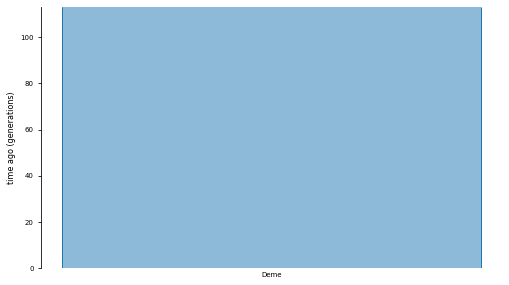

In [6]:
constant = demes.Builder()
constant.add_deme("Deme",epochs=[dict(start_size=N)])
graph = constant.resolve()
demesdraw.tubes(graph, log_time=False, num_lines_per_migration=3)

In [10]:
T,times_dic = slice.sample_timepoints(graph)

In [7]:
# Compute LD 
c_sliced = slice.slice_timepoints(graph,time_points=[0])
c_sliced_LD = get_LD.get_LD_from_sliced_demes(c_sliced)

In [11]:
c_R, c_iicr, _ = model.get_iicr(graph,pop="Deme",T=T)
c_sc = model.size_change_from_iicr(c_iicr,T,time_units="generations",plot=False)

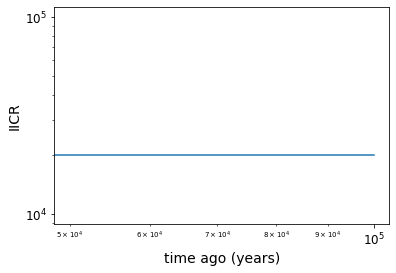

In [12]:
plot_iicr(c_iicr,T)

In [13]:
# Actually slice
c_sc_sliced = slice.slice_timepoints(c_sc,time_points=[0])
c_sc_sliced_LD = get_LD.get_LD_from_sliced_demes(c_sc_sliced)

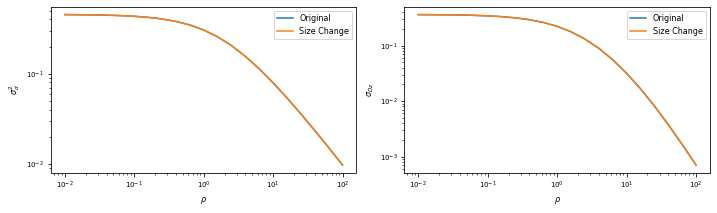

In [14]:
plot_comparison(c_sliced_LD['Deme'][-1],c_sc_sliced_LD['Deme'][-1])

##### 2. Size change - No structure

[{'start_size': 20000.0, 'end_time': 4000.0}, {'start_size': 2000.0, 'end_time': 1000.0}, {'start_size': 10000.0, 'end_time': 0.0}]


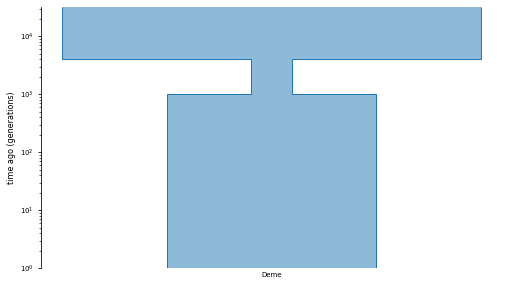

In [15]:
sc_model = size_change(Ns=[N,N/10,N/2],time_period=[time_period,time_period*1.5,time_period/2],time_units="generations")

In [16]:
# Sample times at epochs
T,times_dic = slice.sample_timepoints(sc_model)
# Compute LD 
sc_sliced = slice.slice_timepoints(sc_model,time_points=[0])
sc_sliced_LD = get_LD.get_LD_from_sliced_demes(sc_sliced)

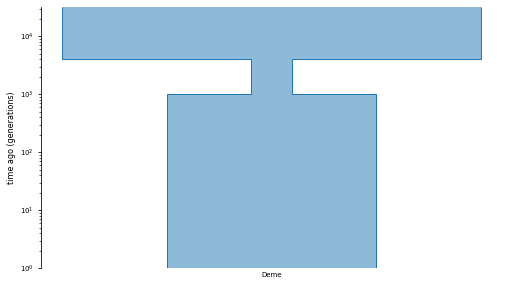

In [17]:
# Get IIRC
sc_R, sc_iicr, _ = model.get_iicr(sc_model,pop="Deme",T=T)
sc_sc = model.size_change_from_iicr(sc_iicr,T,time_units="generations",plot=True)

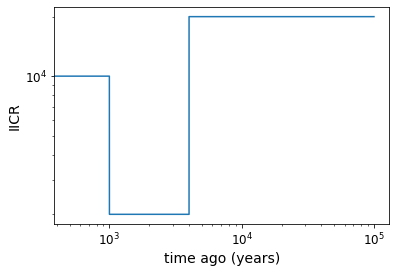

In [18]:
plot_iicr(sc_iicr,T)

In [19]:
# Slice the generated model and get LD
sc_sc_sliced = slice.slice_timepoints(sc_sc,time_points=[0])
sc_sc_sliced_LD = get_LD.get_LD_from_sliced_demes(sc_sc_sliced)

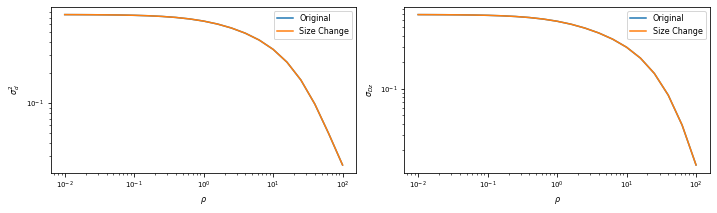

In [20]:
plot_comparison(sc_sliced_LD['Deme'][-1],sc_sc_sliced_LD['Deme'][-1])

##### 3. Bubble, no migration

[Split(parent='Ancestral', children=['Split_01', 'Split_00'], time=200200.0)]


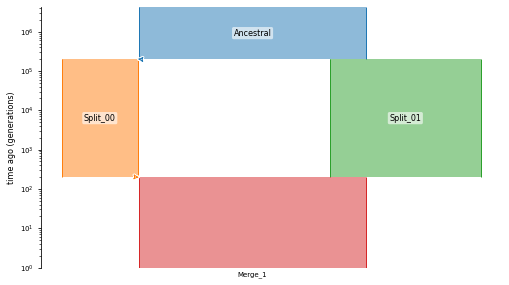

In [6]:
bubble = model.cake_model(Ns=[N,N],splits=[2],proportions=[[1/3,2/3]],time_period_merge=[N,0.01*N],time_period_splits=[N*10],migration_rate=0,generation_time=1)

In [12]:
# Sample times at epochs
T,times_dic = slice.sample_timepoints(bubble,anc_end_time=1e6)
# Compute LD 
b_sliced = slice.slice_timepoints(bubble,time_points=[0])
b_sliced_LD = get_LD.get_LD_from_sliced_demes(b_sliced)

In [8]:
anc_end_time=2e6

In [11]:
anc_end_time

2000000.0

In [10]:
N

20000.0

In [73]:
times_dic

defaultdict(None,
            {'Ancestral': [1999999.0, 1100100.0, 200200.0],
             'Split_00': [200199.0, 100200.0, 200.0],
             'Split_01': [200199.0, 100200.0, 200.0],
             'Merge_1': [199.0, 100.0, 0.0]})

In [74]:
T

array([0.000000e+00, 1.000000e+02, 1.990000e+02, 2.000000e+02,
       1.002000e+05, 2.001990e+05, 2.002000e+05, 1.100100e+06,
       1.999999e+06])

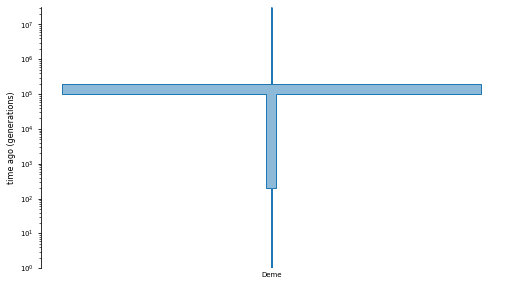

In [13]:
# Get IIRC
b_R, b_iicr, _ = model.get_iicr(bubble,pop="Merge_1",T=T)
b_sc = model.size_change_from_iicr(b_iicr,T,time_units="generations",plot=True)

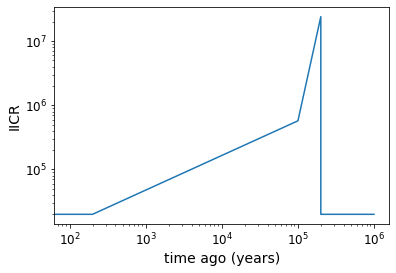

In [14]:
plot_iicr(b_iicr,T)

In [48]:
# Slice the generated model and get LD
b_sc_sliced = slice.slice_timepoints(b_sc,time_points=[0])
b_sc_sliced_LD = get_LD.get_LD_from_sliced_demes(b_sc_sliced)

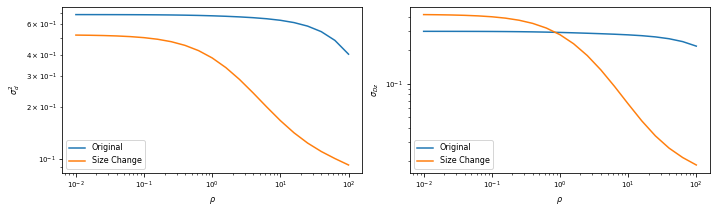

In [49]:
plot_comparison(b_sliced_LD['Merge_1'][-1],b_sc_sliced_LD['Deme'][-1])

##### 4. Isolation with Migration model

<AxesSubplot:ylabel='time ago (generations)'>

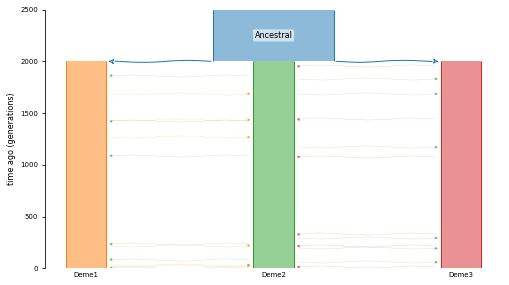

In [189]:
migration_rate1=1e-4
migration_rate2=1e-2

m = demes.Builder(time_units="generations")

#  Add first Ancestor
m.add_deme("Ancestral",epochs=[dict(start_size=N, end_time=time_period)])

m.add_deme("Deme1",ancestors=["Ancestral"],epochs=[dict(start_size=N/3)])
m.add_deme("Deme2",ancestors=["Ancestral"],epochs=[dict(start_size=N/3)])
m.add_deme("Deme3",ancestors=["Ancestral"],epochs=[dict(start_size=N/3)])
m.add_migration(demes = ["Deme1","Deme2"], rate = migration_rate1, end_time=time_period/2)
m.add_migration(demes = ["Deme3","Deme2"], rate = migration_rate1, end_time=time_period/2)

m.add_migration(demes = ["Deme1","Deme2"], rate = migration_rate1, start_time=time_period/6, end_time=1)
m.add_migration(demes = ["Deme3","Deme2"], rate = migration_rate2, start_time=time_period/6 ,end_time=1)

IM = m.resolve()
demesdraw.tubes(IM, log_time=False, num_lines_per_migration=3)

In [198]:
IM.discrete_demographic_events

<bound method Graph.discrete_demographic_events of Graph(description='', time_units='generations', generation_time=1, doi=[], metadata={}, demes=[Deme(name='Ancestral', description='', start_time=inf, ancestors=[], proportions=[], epochs=[Epoch(start_time=inf, end_time=2000.0, start_size=20000.0, end_size=20000.0, size_function='constant', selfing_rate=0, cloning_rate=0)]), Deme(name='Deme1', description='', start_time=2000.0, ancestors=['Ancestral'], proportions=[1.0], epochs=[Epoch(start_time=2000.0, end_time=0, start_size=6666.666666666667, end_size=6666.666666666667, size_function='constant', selfing_rate=0, cloning_rate=0)]), Deme(name='Deme2', description='', start_time=2000.0, ancestors=['Ancestral'], proportions=[1.0], epochs=[Epoch(start_time=2000.0, end_time=0, start_size=6666.666666666667, end_size=6666.666666666667, size_function='constant', selfing_rate=0, cloning_rate=0)]), Deme(name='Deme3', description='', start_time=2000.0, ancestors=['Ancestral'], proportions=[1.0], e

In [ ]:
IM = model.cake_model(Ns=[N,N/3],splits=[3],proportions=[[1/3,1/3,1/3]],time_period_merge=[N,0],time_period_splits=[N],migration_rate=0.02,generation_time=1)

In [197]:
# Sample times at epochs
T,times_dic = slice.sample_timepoints(IM)
# Compute LD 
im_sliced = slice.slice_timepoints(IM,time_points=[0])
im_sliced_LD = get_LD.get_LD_from_sliced_demes(im_sliced)

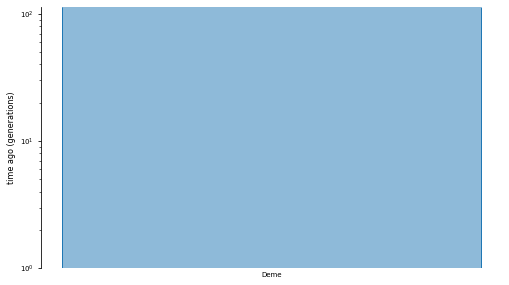

In [202]:
# Get IIRC
im_R,im_iicr, _ = model.get_iicr(IM,pop="Deme1",T=T)
im_sc = model.size_change_from_iicr(im_iicr,times_dic['Deme1'],time_units="generations",plot=True)